<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/Randomized_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA


Populating the interactive namespace from numpy and matplotlib


refer to textbook "data-driven science and engineering"

$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
# Randomized SVD
Singular value decomposition is one of the cornerstones of data science. It is important to have an accurate and efficient SVD decomposition of large matrices. 

In many applications, these matrices usually have the low-rank structure, so we explicitly focus on extracting these dominant low-rank structure in the matrix, rather than getting the full SVD. 

There exists extremely efficient algorithms based on random sampling introduced by Halko, Martinsson, and Tropp. [See referece](https://epubs.siam.org/doi/10.1137/090771806?mobileUi=0). They are called **randomized singular value decomposition**. 


We assume that we are working with tall-skinny matrices $\m{X}\in \mb{R}^{N\times d}$, so that $N>d$,
although the theory readily generalizes to short-fat matrices. 
## Algorithm
### Step 1:
Identify a target rank $r< d$. We construct a random projection matrix $P\in \mb{R}^{d\times r}$ to sample the column space of $\m{X}\in \mb{R}^{N\times r}$: $\m{Z}=\m{X}P$.

The matrix $\m{Z}$ may be much smaller than $\m{X}$, especially for low-rank matrices with $r\ll d$. From the last lecture, with the high probability, a random projection matrix $P$ will project the important components of $\m{X}$ to $\m{Z}$. In other words, $\m{Z}$ approximates the column space of $\m{X}$ with high probability. Thus, it is
possible to compute the low-rank QR decomposition of $\m{Z}$ to obtain an orthonormal basis for $\m{X}$: $\m{Z}= \m{QR}$. where $\m{Q}\in \mb{R}^{N\times r}$ and $\m{R}\in \mb{R}^{r\times r}$.

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/rsvd1.png?raw=true', width=600))

### Step 2:
With the low-rank basis $\m{Q}$, we may project $\m{X}$ into a smaller space: $\m{Y}=\m{Q^\top X}\in \mb{R}^{r\times d}$. 

It also follows that $\m{X} \approx \m{QY}$, with better agreement when the singular values $\sigma_k$ decay
rapidly for $k>r$.

It is now possible to compute the singular value decomposition on $\m{Y}$:  $\m{Y} = \m{U}_{\m{Y}}\Sigma \m{V}^\top$. 

Because $\m{Q}$ is a orthonormal and approximates the column space of $\m{X}$, the matrices $\Sigma$ and
$\m{V}$ are the same for $\m{Y}$ and $\m{X}$.

### Step 3:
Finally, it is possible to reconstruct the high-dimensional left singular vectors $\m{U}$
using $\m{U_Y}$ and $\m{Q}$:

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/rsvd2.png?raw=true', width=600))

## Improvement
### Oversampling 
Most matrices $\m{X}$ do not have an exact low-rank structure, given by $r$ modes. Instead, there
are nonzero singular values $\sigma_k$ for $k>r$,  and the sketch $\m{Z}$ will not exactly span the column
space of $\m{X}$. In general, increasing the number of columns in $P$ from $r$ to $r +p$, significantly
improves results, usually $p\approx 5$ or $10$. This is known as
oversampling, and increasing p decreases the variance of the singular value spectrum of
the sketched matrix.

### Power Iterations

A second challenge in using randomized algorithms is when the singular value spectrum
decays slowly (non-exponetial decay), so that the remaining truncated singular values contain significant variance
in the data $\m{X}$. In this case, it is possible to preprocess $\m{X}$ through $q$ power iterations to create a new matrix $\m{X}^{(q)}$ with a more rapid singular value decay. 
$$ \m{X}^{(q)}= (\m{X}\m{X}^\top)^{q}\m{X}$$

Power iterations dramatically improve the quality of the randomized decomposition, as the
singular value spectrum of $\m{X}^{(q)}$ decays more rapidly. 
$$ \m{X}^{(q)}=\m{U}\Sigma^{2q+1}\m{V}^\top $$

However, power iterations are expensive, requiring $q$ additional passes through the data $\m{X}$.

### Choice of random matrix $P$
Like we talked in the last lecture 
- Gaussian random matrix (expensive to store and compute)
- sparse random projection (improves storage and computation, but at the cost of including less information in the sketch $\m{Z}$)



## Guaranteed Error Bounds

One of the most important properties of the randomized SVD is the existence of tunable
error bounds, that are explicit functions of the singular value spectrum, the desired rank $r$,
the oversampling parameter $p$ and the number of power iterations $q$. 

- The best attainable
error bound for a deterministic algorithm is:
$$ \min \|\m{X}-\m{QY}\|_2 =\sigma_{r+1}(\m{X})$$

- The approximation with the best possible rank-$r$ subspace $\m{Q}$ will have error
greater than or equal to the next truncated singular value of $\m{X}$. For randomized methods, it
is possible to bound the expectation of the error:
$$\sigma_{r+1}(\m{X}) \le \mb{E}(\m{X}-\m{QY}\|_2)\le \left(1+\sqrt{\frac{r}{p-1}}+\frac{e\sqrt{r+p}}{p}\sqrt{\min(N,d)-r}\right)^{\frac{1}{2q+1}}\sigma_{r+1}(\m{X})$$



In [2]:
# Define randomized SVD function
def rSVD(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    N = X.shape[1]
    P = np.random.randn(N,r+p)
    Z = X @ P
    for k in range(q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z,mode='reduced')

    # Step 2: Compute SVD on projected Y = Q.T @ X
    Y = Q.T @ X
    UY, S, VT = np.linalg.svd(Y,full_matrices=0)

    # Step 3: Compute U
    U = Q @ UY

    return U, S, VT

In [10]:

!wget https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/jupiter.jpg?raw=true -O img.jpg

--2022-01-15 21:49:41--  https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/jupiter.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yexf308/AdvancedMachineLearning/raw/main/image/jupiter.jpg [following]
--2022-01-15 21:49:41--  https://github.com/yexf308/AdvancedMachineLearning/raw/main/image/jupiter.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yexf308/AdvancedMachineLearning/main/image/jupiter.jpg [following]
--2022-01-15 21:49:41--  https://raw.githubusercontent.com/yexf308/AdvancedMachineLearning/main/image/jupiter.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

In [14]:
import cv2
from time import time
img = cv2.imread('img.jpg')
X = np.mean(img,axis=2) # Convert RGB -> grayscale

t0 = time()
U, S, VT = np.linalg.svd(X,full_matrices=0) # Deterministic SVD
print(f"Deterministic SVD takes {time() - t0}s")

r = 400 # Target rank
q = 1   # Power iterations
p = 5   # Oversampling parameter

t0 = time()
rU, rS, rVT = rSVD(X,r,q,p)
print(f"randomized SVD takes {time() - t0}s")

Deterministic SVD takes 10.517197608947754s
randomized SVD takes 1.091355800628662s


In [22]:
## Reconstruction
XSVD = U[:,:(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1),:] # SVD approximation
errSVD = np.linalg.norm(X-XSVD,ord=2) / np.linalg.norm(X,ord=2)
print(f'In deterministic SVD, 2-norm of relative error is {errSVD}s')
XrSVD = rU[:,:(r+1)] @ np.diag(rS[:(r+1)]) @ rVT[:(r+1),:] # SVD approximation
errSVD = np.linalg.norm(X-XrSVD,ord=2) / np.linalg.norm(X,ord=2)
print(f'In randomized SVD, 2-norm of relative error is {errSVD}s')

In deterministic SVD, 2-norm of relative error is 0.00039007051775193677s
In randomized SVD, 2-norm of relative error is 0.0005076927510275155s


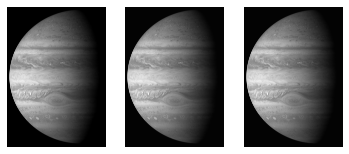

In [16]:
## Plot
fig, axs = plt.subplots(1,3)

plt.set_cmap('gray')
axs[0].imshow(X)
axs[0].axis('off')
axs[1].imshow(XSVD)
axs[1].axis('off')
axs[2].imshow(XrSVD)
axs[2].axis('off')

plt.show()

In [37]:
r_range = range(10)
errSVD  = zeros(10)
for index, r in enumerate(r_range):
  rU, rS, rVT = rSVD(X,r,q,p)
  XrSVD = rU[:,:(r+1)] @ np.diag(rS[:(r+1)]) @ rVT[:(r+1),:]
  errSVD[index] = np.linalg.norm(X-XrSVD,ord=2) 



In [41]:
print('The following values are the actual 2-norm error incurred ')
print(errSVD)
print('The following values are the singular values k+1 of X. These indicate the theoretically minimal approximation error.')
print(S[1:11])

The following values are the actual 2-norm error incurred 
[54873.03348388 31904.36127882 21423.6691176  17257.88166823
 13128.23555263 11299.51255863  9688.70694201  8559.56344596
  8045.70117014  6893.78829327]
The following values are the singular values k+1 of X. These indicate the theoretically minimal approximation error.
[54873.03347752 31904.36076904 21423.2173802  17257.79855045
 13119.21547839 11291.13531406  9676.15611438  8296.18423313
  7946.09945592  6871.86714995]


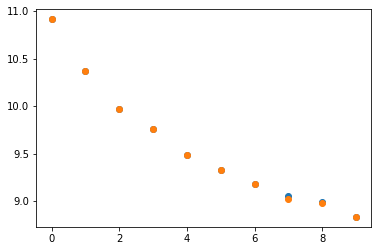

In [40]:
scatter(range(10),log(errSVD))
scatter(range(10),log(S[1:11]))